In [1]:
!pip install -q -U autogluon.tabular ray

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.13.0 requires aiohttp<4.0.0,>=3.9.2, which is not installed.
s3fs 2024.3.1 requires aiohttp!=4.0.0a0,!=4.0.0a1, which is not installed.
aiobotocore 2.13.0 requires botocore<1.34.107,>=1.34.70, but you have botocore 1.29.165 which is incompatible.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.


# Imports and Configs

In [2]:
from autogluon.tabular import TabularPredictor, TabularDataset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc, accuracy_score
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import shutil
import pickle
import glob

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
sns.set_palette('husl')

In [3]:
TIME_LIMIT = 3600 * 10
N_FOLDS = 5
SEED = 27
TARGET = 'Target'

# Loading the Datasets

In [4]:
train = pd.read_csv('/kaggle/input/playground-series-s4e6/train.csv', index_col='id')
test = pd.read_csv('/kaggle/input/playground-series-s4e6/test.csv', index_col='id')

train.shape, test.shape

((76518, 37), (51012, 36))

In [5]:
cat_features = [
    'Marital status',
    'Application mode',
    'Course',
    'Previous qualification',
    'Nacionality',
    "Mother's qualification",
    "Father's qualification",
    "Mother's occupation",
    "Father's occupation"
]
for feature in cat_features:
    train[feature] = train[feature].astype('category')
    test[feature] = test[feature].astype('category')

In [6]:
train = TabularDataset(train)
test = TabularDataset(test)

# Training

In [7]:
skf = StratifiedKFold(n_splits=N_FOLDS, random_state=SEED, shuffle=True)

histories = {}
oof_preds = np.zeros((len(train), train[TARGET].nunique()))
for fold_idx, (train_idx, val_idx) in enumerate(skf.split(train.drop(columns=TARGET), train[TARGET])):
    _train, _val = train.iloc[train_idx], train.iloc[val_idx]    

    predictor = TabularPredictor(
        label=TARGET,
        eval_metric='accuracy',
        problem_type='multiclass',
        verbosity=2
    ).fit(
        train_data=_train,
        time_limit=TIME_LIMIT // N_FOLDS,
        presets='best_quality',
        save_space=True,
#         hyperparameter_tune_kwargs={  
#             'num_trials': 25,
#             'scheduler' : 'local',
#             'searcher'  : 'auto'
#         },
#         feature_prune_kwargs={'force_prune': True}
    )
    
    fold_score = predictor.evaluate(_val, silent=True)['accuracy']
    
    pred_probs = predictor.predict_proba(_val)
    preds = pred_probs.idxmax(axis=1).values
    oof_preds[val_idx] = pred_probs
    
    test_pred_probs = predictor.predict_proba(test)
    
    test_preds = test_pred_probs.idxmax(axis=1).values
    test_preds = pd.DataFrame({TARGET: test_preds}, index=test.index)
    test_preds.to_csv(f'fold_{fold_idx}_test_preds_acc-{fold_score:.6f}.csv')
    
    test_pred_probs = pd.DataFrame(test_pred_probs, index=test.index)
    test_pred_probs.to_csv(f'fold_{fold_idx}_test_pred_probs_acc-{fold_score:.6f}.csv')
    
    histories[f'Fold {fold_idx}'] = {}
    histories[f'Fold {fold_idx}']['y'] = _val[TARGET].values
    histories[f'Fold {fold_idx}']['pred_probs'] = pred_probs
    histories[f'Fold {fold_idx}']['preds'] = preds
    histories[f'Fold {fold_idx}']['accuracy'] = fold_score
    histories[f'Fold {fold_idx}']['auc'] = roc_auc_score(_val[TARGET], pred_probs, multi_class='ovo')
    
    histories[f'Fold {fold_idx}']['leaderboard'] = predictor.leaderboard(_val, silent=True)
    if fold_idx == 1:
        histories[f'Fold {fold_idx}']['feature_importance'] = predictor.feature_importance(_val, silent=True)
    
    
    print(f'Fold {fold_idx} - Accuracy: {fold_score}')
    
    shutil.rmtree("AutogluonModels")
    del predictor

No path specified. Models will be saved in: "AutogluonModels/ag-20240604_032435"
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 7200 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240604_032435/ds_sub_fit/sub_fit_ho.
2024-06-04 03:24:36,399	INFO util.py:124 -- Outdated packages:
  ipywidgets==7

Fold 0 - Accuracy: 0.8364479874542603


No path specified. Models will be saved in: "AutogluonModels/ag-20240604_052830"
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 7200 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240604_052830/ds_sub_fit/sub_fit_ho.
Beginning AutoGluon training ... Time limit = 1800s
AutoGluon will save models

Fold 1 - Accuracy: 0.8350104547830632


No path specified. Models will be saved in: "AutogluonModels/ag-20240604_073303"
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 7200 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240604_073303/ds_sub_fit/sub_fit_ho.
Beginning AutoGluon training ... Time limit = 1800s
AutoGluon will save models

Fold 2 - Accuracy: 0.8333115525352849


No path specified. Models will be saved in: "AutogluonModels/ag-20240604_093645"
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 7200 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240604_093645/ds_sub_fit/sub_fit_ho.
Beginning AutoGluon training ... Time limit = 1800s
AutoGluon will save models

Fold 3 - Accuracy: 0.8336927399856238


No path specified. Models will be saved in: "AutogluonModels/ag-20240604_113849"
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 7200 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240604_113849/ds_sub_fit/sub_fit_ho.
Beginning AutoGluon training ... Time limit = 1800s
AutoGluon will save models

Fold 4 - Accuracy: 0.8252630203228125


In [8]:
with open('ag_oof_preds.pkl', 'wb') as f:
    pickle.dump(oof_preds, f)

In [9]:
mappings = {v: k for k, v in enumerate(histories['Fold 0']['pred_probs'].columns)}
reverse_mappings = {v: k for k, v in mappings.items()}

In [10]:
histories['All'] = {}
histories['All']['accuracy'] = accuracy_score(train[TARGET].map(mappings), oof_preds.argmax(axis=1))
histories['All']['auc'] = roc_auc_score(train[TARGET], oof_preds, multi_class='ovo')
histories['All']['pred_probs'] = oof_preds
histories['All']['preds'] = oof_preds.argmax(axis=1)
histories['All']['y'] = train[TARGET].values

# Results

In [11]:
histories['Fold 0']['leaderboard'].style.background_gradient(subset=['score_val'], cmap='RdYlGn')

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,NeuralNetFastAI_BAG_L2,0.837101,0.832653,accuracy,36.843547,42.693808,4207.447614,3.179661,1.666305,682.018411,2,True,16
1,LightGBM_BAG_L1,0.836840,0.832391,accuracy,4.277472,2.116188,61.609364,4.277472,2.116188,61.609364,1,True,5
2,WeightedEnsemble_L2,0.836840,0.832391,accuracy,4.280552,2.124640,64.553800,0.003080,0.008452,2.944436,2,True,15
3,ExtraTreesGini_BAG_L2,0.836840,0.830807,accuracy,35.001291,46.311230,3541.545786,1.337405,5.283727,16.116583,2,True,22
4,LightGBMXT_BAG_L2,0.836448,0.833518,accuracy,34.942986,41.714877,3595.865539,1.279100,0.687374,70.436336,2,True,17
5,WeightedEnsemble_L3,0.836448,0.833518,accuracy,34.945848,41.723818,3600.892831,0.002862,0.008940,5.027292,3,True,26
6,RandomForestEntr_BAG_L2,0.836317,0.830170,accuracy,34.505143,45.828919,3589.135947,0.841258,4.801416,63.706743,2,True,20
7,ExtraTreesEntr_BAG_L2,0.836317,0.830268,accuracy,35.002352,46.327913,3540.949667,1.338466,5.300411,15.520463,2,True,23
8,NeuralNetTorch_BAG_L2,0.836187,0.832032,accuracy,35.442047,42.095706,3754.535744,1.778161,1.068203,229.106541,2,True,25
9,XGBoost_BAG_L2,0.835991,0.832816,accuracy,35.125869,41.942413,3608.934733,1.461983,0.914910,83.505529,2,True,24


In [12]:
histories['Fold 1']['leaderboard'].style.background_gradient(subset=['score_val'], cmap='RdYlGn')

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBM_BAG_L1,0.835010,0.831640,accuracy,3.687112,1.831318,55.784694,3.687112,1.831318,55.784694,1,True,5
1,WeightedEnsemble_L2,0.835010,0.831640,accuracy,3.690041,1.839766,58.964921,0.002928,0.008448,3.180226,2,True,16
2,XGBoost_BAG_L1,0.834880,0.830970,accuracy,3.280715,1.667840,152.184340,3.280715,1.667840,152.184340,1,True,11
3,LightGBMLarge_BAG_L1,0.834814,0.829794,accuracy,4.448902,2.180438,85.484479,4.448902,2.180438,85.484479,1,True,13
4,LightGBMXT_BAG_L1,0.833769,0.830562,accuracy,6.869823,3.462239,77.577561,6.869823,3.462239,77.577561,1,True,4
5,CatBoost_r177_BAG_L1,0.832331,0.829745,accuracy,0.238562,0.272815,1068.013835,0.238562,0.272815,1068.013835,1,True,14
6,CatBoost_BAG_L1,0.831809,0.829745,accuracy,0.413018,0.300444,2487.119648,0.413018,0.300444,2487.119648,1,True,8
7,RandomForestGini_BAG_L1,0.830698,0.823798,accuracy,2.107768,4.080336,18.647627,2.107768,4.080336,18.647627,1,True,6
8,RandomForestEntr_BAG_L1,0.829130,0.824207,accuracy,1.402565,4.017396,18.908166,1.402565,4.017396,18.908166,1,True,7
9,NeuralNetFastAI_BAG_L1,0.828999,0.826445,accuracy,3.067440,1.476640,654.521108,3.067440,1.476640,654.521108,1,True,3


In [13]:
histories['Fold 2']['leaderboard'].style.background_gradient(subset=['score_val'], cmap='RdYlGn')

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,XGBoost_BAG_L1,0.834422,0.832212,accuracy,3.610463,1.811253,151.143637,3.610463,1.811253,151.143637,1,True,11
1,NeuralNetFastAI_BAG_L2,0.834422,0.832538,accuracy,35.148486,39.082438,4177.630525,3.203837,1.543265,643.062261,2,True,17
2,XGBoost_BAG_L2,0.834226,0.832996,accuracy,33.473157,38.507483,3628.338516,1.528508,0.968311,93.770252,2,True,25
3,CatBoost_BAG_L2,0.834030,0.832669,accuracy,32.094395,37.721746,4006.109918,0.149746,0.182573,471.541654,2,True,22
4,LightGBMXT_BAG_L2,0.833965,0.832228,accuracy,32.642228,37.933358,3597.859007,0.697579,0.394185,63.290742,2,True,18
5,LightGBMLarge_BAG_L1,0.833508,0.832277,accuracy,6.267708,3.077942,102.874440,6.267708,3.077942,102.874440,1,True,13
6,WeightedEnsemble_L2,0.833508,0.832277,accuracy,6.270640,3.086901,106.093899,0.002932,0.008958,3.219460,2,True,16
7,LightGBM_BAG_L2,0.833312,0.833077,accuracy,32.606687,37.965796,3603.953490,0.662038,0.426623,69.385226,2,True,19
8,WeightedEnsemble_L3,0.833312,0.833077,accuracy,32.609505,37.974336,3608.926331,0.002818,0.008541,4.972841,3,True,27
9,NeuralNetTorch_BAG_L2,0.833246,0.831820,accuracy,33.754644,38.667726,3754.406907,1.809994,1.128553,219.838643,2,True,26


In [14]:
histories['Fold 3']['leaderboard'].style.background_gradient(subset=['score_val'], cmap='RdYlGn')

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.833693,0.833015,accuracy,16.794287,16.342478,2737.263555,0.009911,0.008567,3.298277,2,True,17
1,XGBoost_BAG_L1,0.832843,0.832590,accuracy,3.846293,1.848770,163.839283,3.846293,1.848770,163.839283,1,True,11
2,LightGBM_BAG_L1,0.832647,0.832133,accuracy,3.977426,1.981016,58.177996,3.977426,1.981016,58.177996,1,True,5
3,LightGBMLarge_BAG_L1,0.831863,0.831234,accuracy,5.630241,2.717824,92.333296,5.630241,2.717824,92.333296,1,True,13
4,LightGBMXT_BAG_L1,0.831863,0.831152,accuracy,6.544569,3.147825,75.716681,6.544569,3.147825,75.716681,1,True,4
5,CatBoost_r177_BAG_L1,0.831210,0.830581,accuracy,0.281569,0.277591,1550.928710,0.281569,0.277591,1550.928710,1,True,14
6,CatBoost_BAG_L1,0.829511,0.828784,accuracy,0.296167,0.235232,1771.812268,0.296167,0.235232,1771.812268,1,True,8
7,NeuralNetFastAI_BAG_L1,0.829053,0.826431,accuracy,3.128461,1.500684,653.134961,3.128461,1.500684,653.134961,1,True,3
8,RandomForestEntr_BAG_L1,0.827746,0.826023,accuracy,1.764774,4.035587,18.846948,1.764774,4.035587,18.846948,1,True,7
9,NeuralNetTorch_r79_BAG_L1,0.827681,0.826284,accuracy,1.265061,0.832561,279.074819,1.265061,0.832561,279.074819,1,True,15


In [15]:
histories['Fold 4']['leaderboard'].style.background_gradient(subset=['score_val'], cmap='RdYlGn')

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBMXT_BAG_L1,0.825916,0.831414,accuracy,5.971854,2.937198,72.784873,5.971854,2.937198,72.784873,1,True,4
1,LightGBMLarge_BAG_L1,0.825394,0.833554,accuracy,8.204377,2.783473,94.024496,8.204377,2.783473,94.024496,1,True,13
2,WeightedEnsemble_L2,0.825263,0.834077,accuracy,7.005058,3.304274,191.620061,0.004564,0.008722,3.243459,2,True,16
3,XGBoost_BAG_L1,0.825198,0.834060,accuracy,3.444964,1.498929,133.193969,3.444964,1.498929,133.193969,1,True,11
4,LightGBM_BAG_L1,0.825067,0.833668,accuracy,3.555530,1.796623,55.182633,3.555530,1.796623,55.182633,1,True,5
5,CatBoost_r177_BAG_L1,0.825002,0.832623,accuracy,0.398204,0.314905,1811.741962,0.398204,0.314905,1811.741962,1,True,14
6,NeuralNetFastAI_BAG_L1,0.823760,0.827902,accuracy,3.085968,1.508581,698.700183,3.085968,1.508581,698.700183,1,True,3
7,CatBoost_BAG_L1,0.822322,0.830711,accuracy,0.286662,0.219295,1662.366825,0.286662,0.219295,1662.366825,1,True,8
8,NeuralNetTorch_BAG_L1,0.822192,0.827183,accuracy,1.149598,0.677298,613.473444,1.149598,0.677298,613.473444,1,True,12
9,NeuralNetTorch_r79_BAG_L1,0.821277,0.825892,accuracy,1.563301,0.790585,123.068860,1.563301,0.790585,123.068860,1,True,15


In [16]:
histories['Fold 1']['feature_importance'].style.background_gradient(subset=['importance'], cmap='RdYlGn')

,importance,stddev,p_value,n,p99_high,p99_low
Curricular units 2nd sem (approved),0.188560,0.007618,0.000000,5,0.204245,0.172875
Tuition fees up to date,0.037880,0.001641,0.000000,5,0.041258,0.034502
Curricular units 1st sem (approved),0.018320,0.002086,0.000020,5,0.022615,0.014025
Course,0.010960,0.002360,0.000243,5,0.015819,0.006101
Curricular units 2nd sem (grade),0.008080,0.001988,0.000406,5,0.012173,0.003987
Scholarship holder,0.006680,0.001487,0.000276,5,0.009742,0.003618
Curricular units 2nd sem (evaluations),0.006600,0.003521,0.006898,5,0.013851,-0.000651
Curricular units 1st sem (evaluations),0.003000,0.001208,0.002575,5,0.005488,0.000512
Age at enrollment,0.002800,0.001772,0.012080,5,0.006449,-0.000849
Curricular units 2nd sem (enrolled),0.002480,0.002460,0.043621,5,0.007545,-0.002585


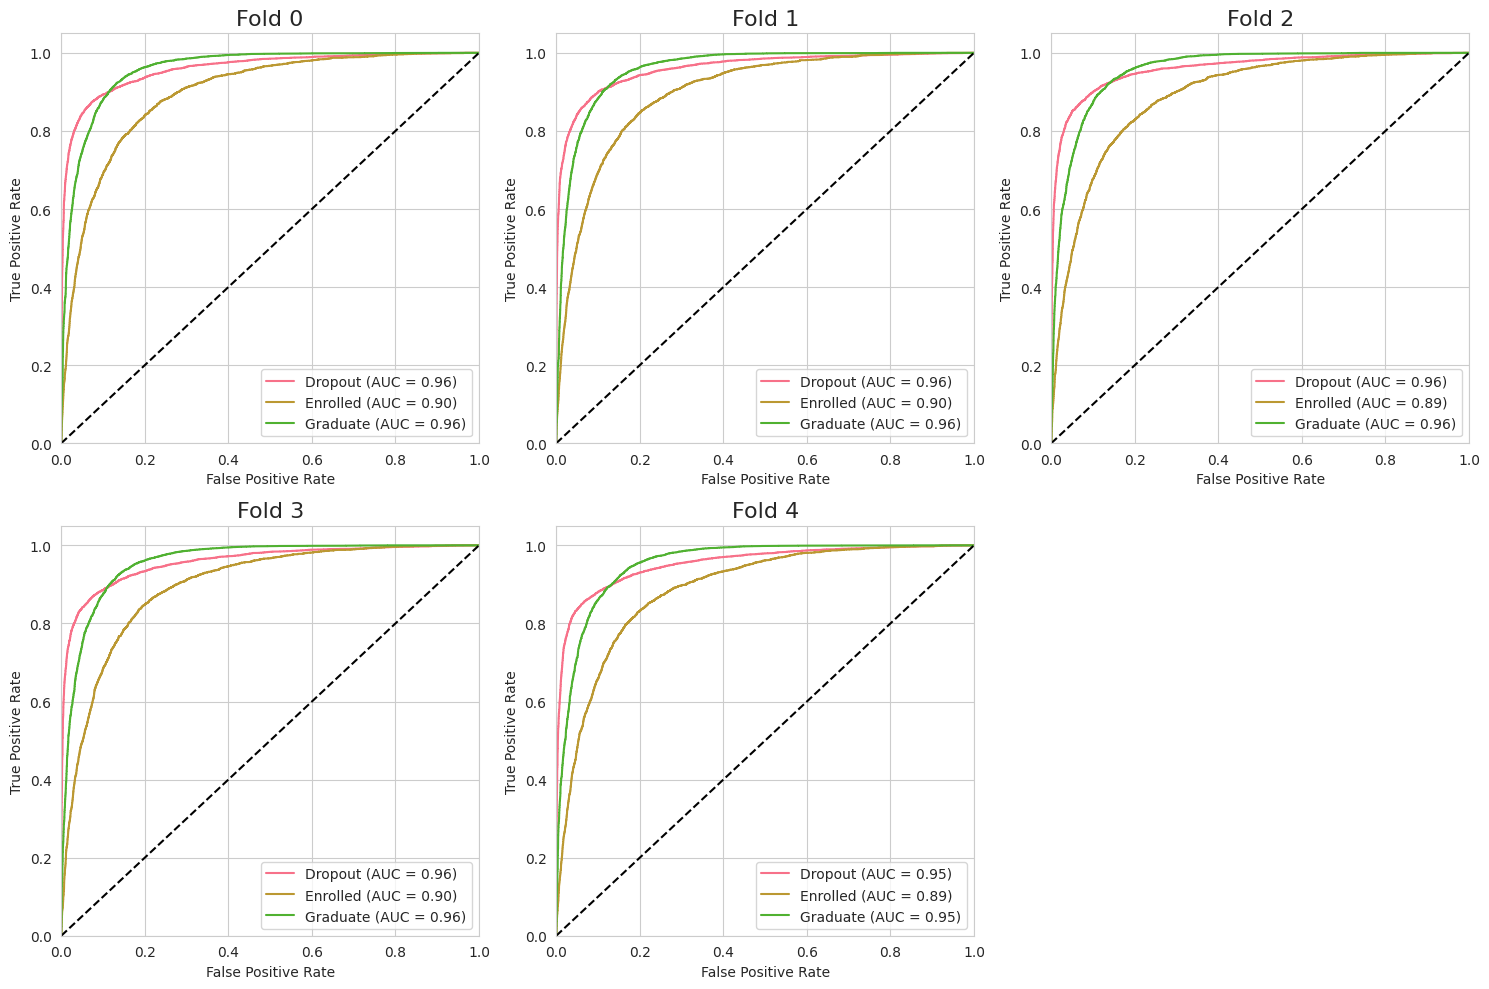

In [17]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for fold_idx, ax in enumerate(axes.flatten()):
    if f'Fold {fold_idx}' not in histories:
        fig.delaxes(ax)
        continue

    pred_probs = histories[f'Fold {fold_idx}']['pred_probs']
    preds = histories[f'Fold {fold_idx}']['preds']
    y = histories[f'Fold {fold_idx}']['y']

    preds = np.array([mappings[p] for p in preds])
    y = np.array([mappings[p] for p in y])

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(pred_probs.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(y == i, pred_probs.values[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    for i in range(pred_probs.shape[1]):
        ax.plot(fpr[i], tpr[i], label=f'{reverse_mappings[i]} (AUC = {roc_auc[i]:.2f})')

    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'Fold {fold_idx}', fontsize=16)
    ax.legend()

plt.tight_layout()
plt.show()

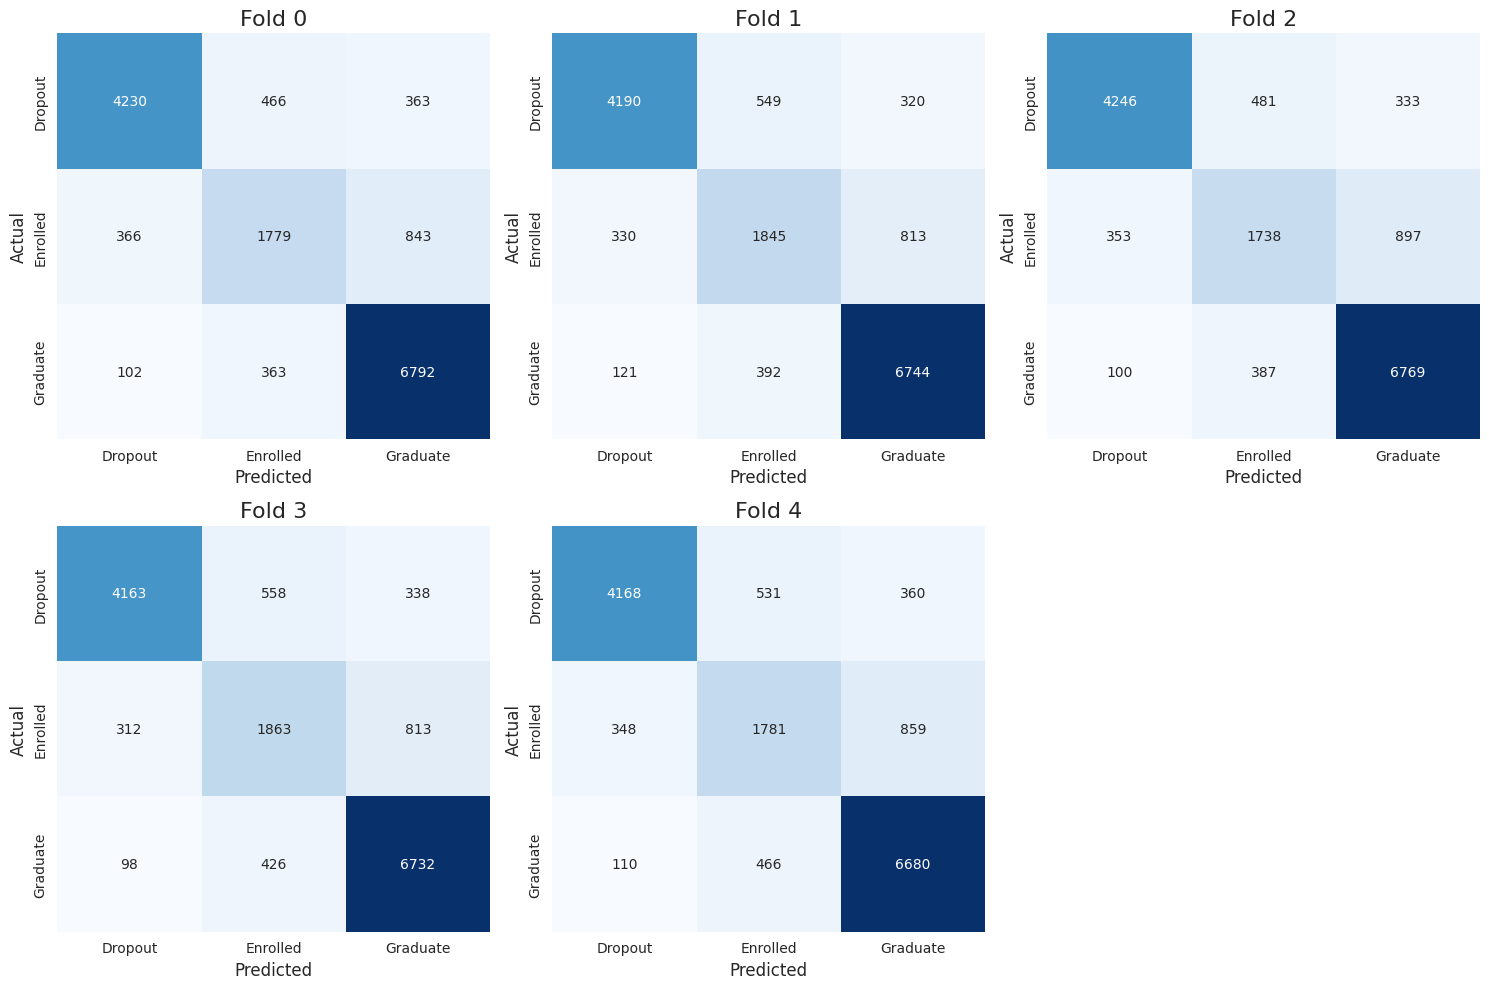

In [18]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for fold_idx, ax in enumerate(axes.flatten()):
    if f'Fold {fold_idx}' not in histories:
        fig.delaxes(ax)
        continue

    preds = histories[f'Fold {fold_idx}']['preds']
    y = histories[f'Fold {fold_idx}']['y']

    preds = np.array([mappings[p] for p in preds])
    y = np.array([mappings[p] for p in y])

    cm = confusion_matrix(y, preds)
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        ax=ax,
        cmap='Blues',
        cbar=False,
        xticklabels=reverse_mappings.values(),
        yticklabels=reverse_mappings.values()
    )

    ax.set_xlabel('Predicted', fontsize=12)
    ax.set_ylabel('Actual', fontsize=12)
    ax.set_title(f'Fold {fold_idx}', fontsize=16)

plt.tight_layout()
plt.show()

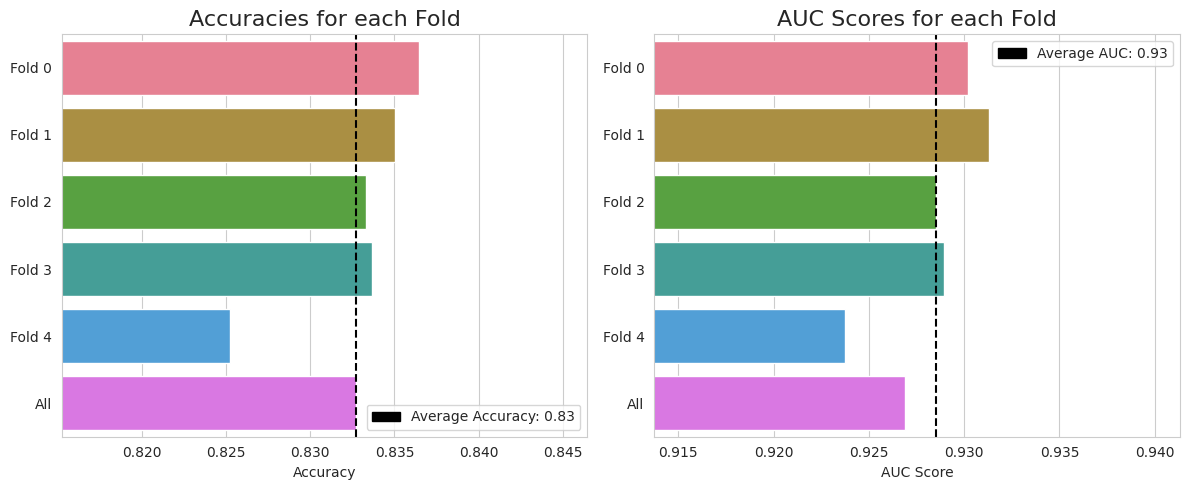

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

accuracies = [histories[f'Fold {i}']['accuracy'] for i in range(N_FOLDS)]
mean_accuracy = np.mean(accuracies)
accuracies = accuracies + [histories['All']['accuracy']]

sns.barplot(y=[f'Fold {i}' for i in range(N_FOLDS)] + ['All'], x=accuracies, ax=axs[0], palette='husl', orient='h')
axs[0].axvline(mean_accuracy, color='black', linestyle='--')
axs[0].set_xlim([min(accuracies) - 0.01, max(accuracies) + 0.01])
axs[0].set_xlabel('Accuracy')
axs[0].set_title('Accuracies for each Fold', fontsize=16)
blue_patch = mpatches.Patch(color='black', label=f'Average Accuracy: {mean_accuracy:.2f}')
axs[0].legend(handles=[blue_patch], loc='best')


auc_scores = [histories[f'Fold {i}']['auc'] for i in range(N_FOLDS)]
mean_auc = np.mean(auc_scores)
auc_scores = auc_scores + [histories['All']['auc']]

sns.barplot(y=[f'Fold {i}' for i in range(N_FOLDS)] + ['All'], x=auc_scores, ax=axs[1], palette='husl', orient='h')
axs[1].axvline(mean_auc, color='black', linestyle='--')
axs[1].set_xlim([min(auc_scores) - 0.01, max(auc_scores) + 0.01])
axs[1].set_xlabel('AUC Score')
axs[1].set_title('AUC Scores for each Fold', fontsize=16)
blue_patch = mpatches.Patch(color='black', label=f'Average AUC: {mean_auc:.2f}')
axs[1].legend(handles=[blue_patch], loc='best')

plt.tight_layout()
plt.show()

# Inference

In [20]:
files = glob.glob('fold_*_test_pred_probs_*.csv')
submissions = [pd.read_csv(f, index_col='id') for f in files]

submission = pd.concat(submissions, axis=1)
submission = submission.groupby(level=0, axis=1).mean()

submission['Target'] = submission.idxmax(axis=1)
submission['id'] = submission.index
submission = submission[['id', 'Target']]

submission.to_csv(f'ag_acc-{mean_accuracy:.6f}_auc-{mean_auc:.6f}.csv', index=False)
submission.head()

,id,Target
id,,
76518,76518,Dropout
76519,76519,Graduate
76520,76520,Graduate
76521,76521,Graduate
76522,76522,Enrolled
